In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt


from state_lookup import state_lookup


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
##### USA #### llcrnrlat=20.,llcrnrlon=-135.,urcrnrlat=56.,urcrnrlon=-55.,lat_0=39.5, lon_0=-80,
## Bay Area ##

In [13]:
state_lookup.get_state_num('California')

6

/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


(23212,
 5,
 [-124.48200299999999, 32.528832, 0.0, 0.0],
 [-114.131211, 42.009502999999995, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x133631a20>)

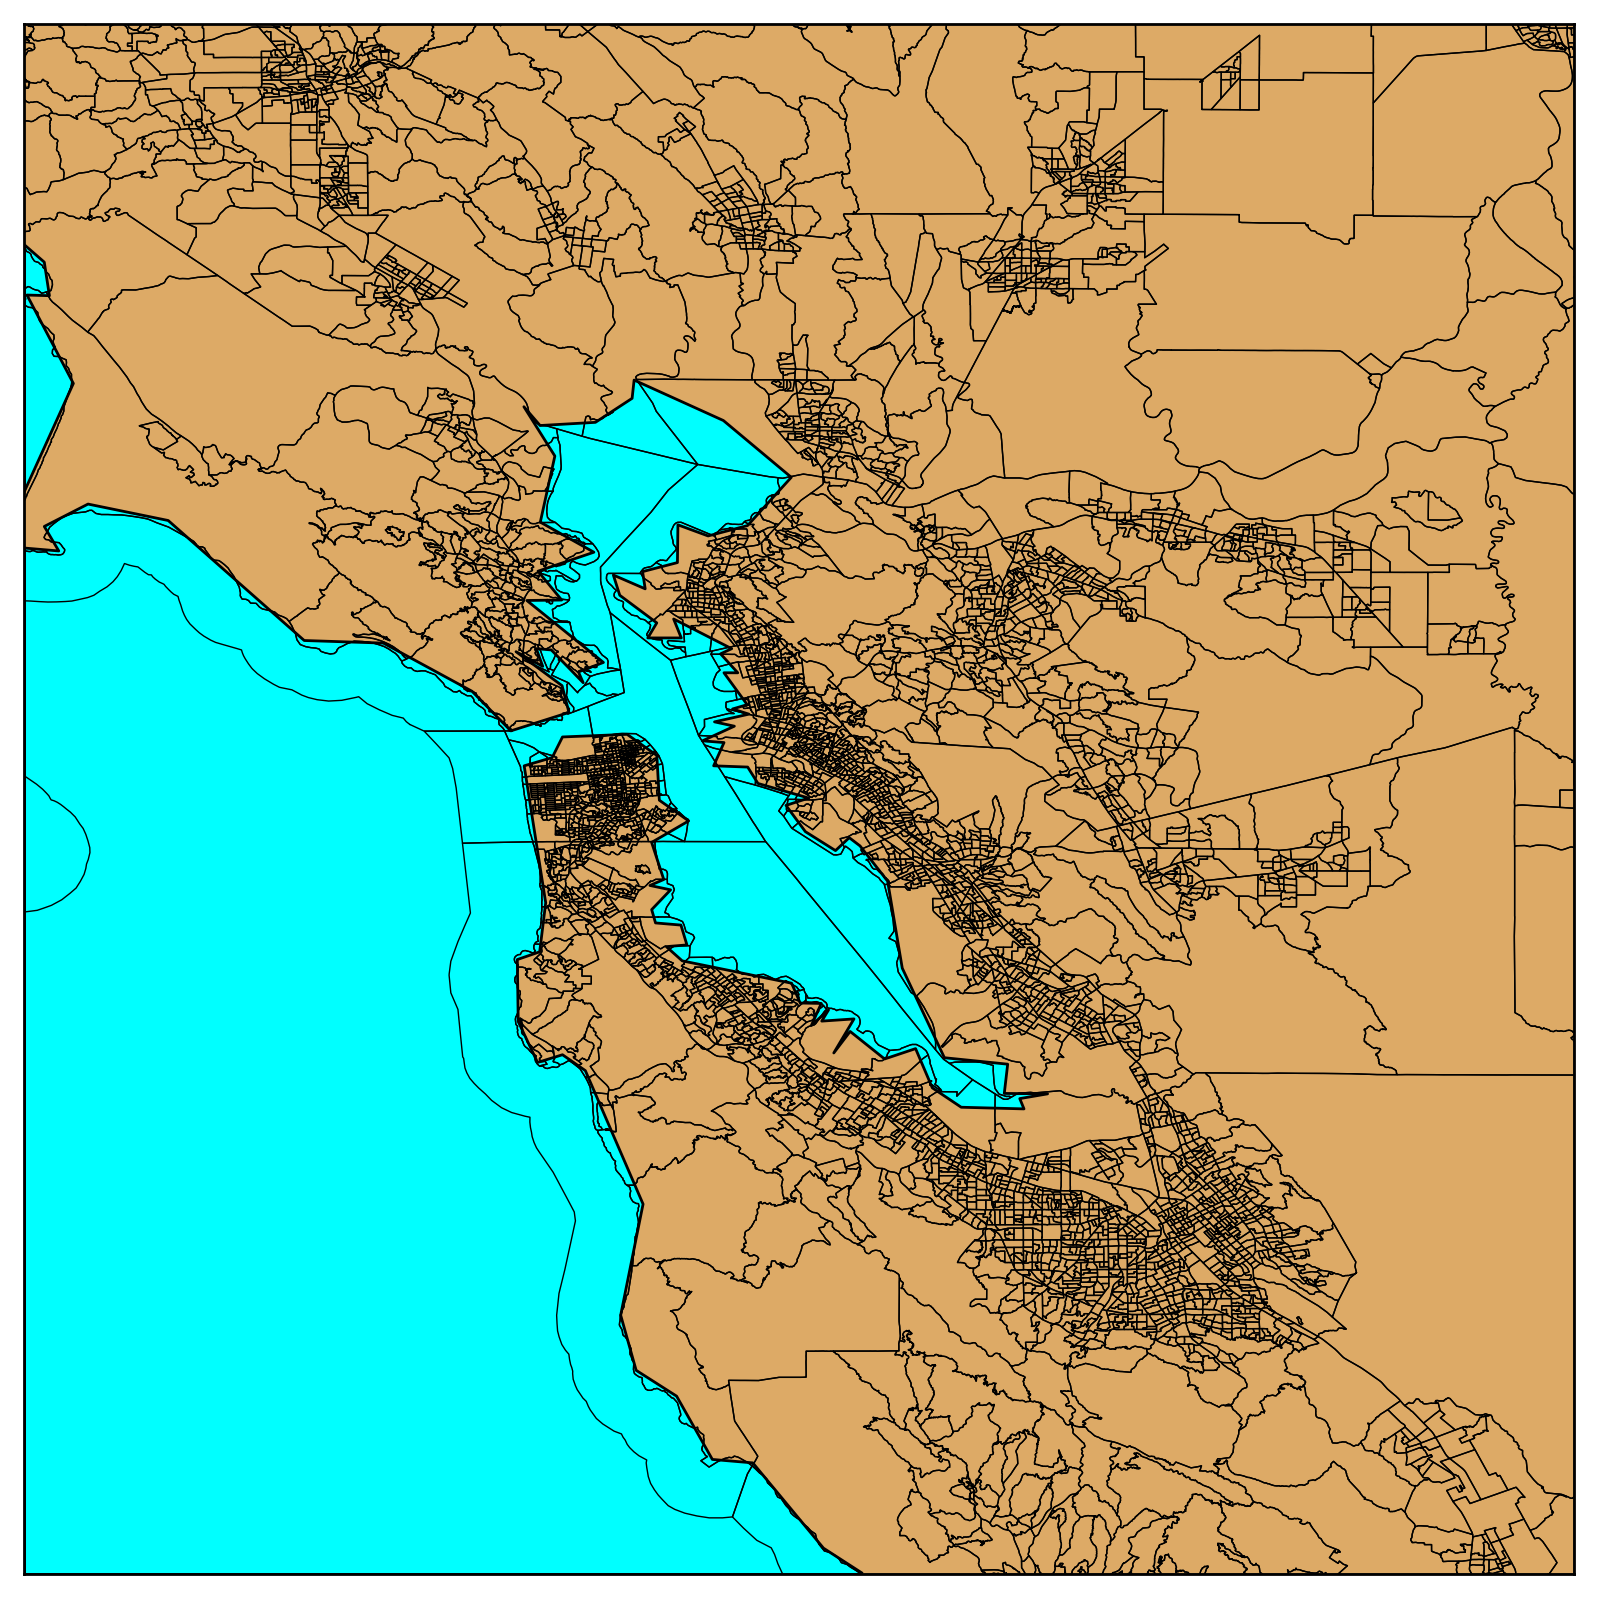

In [27]:
plt.figure(figsize=(10,20),dpi=200)
map = Basemap(llcrnrlat=37.,llcrnrlon=-123.,urcrnrlat=38.5,urcrnrlon=-121.5,lat_0=37.75, lon_0=-122.5,
             resolution='i', 
    projection='cyl')

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='#ddaa66',lake_color='aqua')
map.drawcoastlines()

map.readshapefile('/Users/ryanduecker/Desktop/BG/tl_2016_06_bg/tl_2016_06_bg', '06_bg')

In [34]:
import os

blockpop_filelist = []
blockhome_filelist = []
for a,b,c in os.walk('/Users/ryanduecker/git/public_transit_usability/public_transit_usability/data/tab4/sumfile/prod/2012thru2016/group2'):
    for file in c:
        if file[0] == 'e':
            if file[8:12]=='0001':
                blockpop_filelist.append(file)
            elif file[8:12]=='0002':
                blockhome_filelist.append(file)


df_pop = pd.DataFrame()
for file in blockpop_filelist:
    try:
        df = pd.read_csv('/Users/ryanduecker/git/public_transit_usability/public_transit_usability/data/tab4/sumfile/prod/2012thru2016/group2/' + file)
        df_pop = df_pop.append(df)
    except:
        print(file)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


e20165us0001000.txt


In [36]:
pd.read_csv('/Users/ryanduecker/git/public_transit_usability/public_transit_usability/data/tab4/sumfile/prod/2012thru2016/group2/e20165ca0001000.txt')

,ACSSF,2016e5,ca,000,0001,0002699,324,144
0,ACSSF,201600000.0,ca,0,1,2700,322.0,144.0
1,ACSSF,201600000.0,ca,0,1,2701,302.0,144.0
2,ACSSF,201600000.0,ca,0,1,2702,359.0,172.0
3,ACSSF,201600000.0,ca,0,1,2703,313.0,148.0
4,ACSSF,201600000.0,ca,0,1,2704,225.0,102.0
5,ACSSF,201600000.0,ca,0,1,2705,363.0,161.0
6,ACSSF,201600000.0,ca,0,1,2706,265.0,140.0
7,ACSSF,201600000.0,ca,0,1,2707,207.0,110.0
8,ACSSF,201600000.0,ca,0,1,2708,316.0,136.0
9,ACSSF,201600000.0,ca,0,1,2709,224.0,107.0


In [2]:
df = pd.read_csv('population_by_zip_2010.csv')

FileNotFoundError: File b'population_by_zip_2010.csv' does not exist

In [17]:
zip_pop = df.groupby('zipcode').sum()[['population']]

In [18]:
zip_pop = zip_pop.reset_index()

In [21]:
sta = pd.read_csv('station_locations.csv')

In [24]:
sta['zipcode'] = sta['station'].apply(lambda x: int(x.split(', ')[-1]))

In [25]:
sta.merge(zip_pop, on='zipcode')

,latatude,longitude,raw,station,zipcode,population
0,37.797385,-122.265300,"{u'lat': 37.797385, u'lng': -122.2653001}","800 Madison Street, Oakland, CA, 94607",94607,74934
1,37.804875,-122.295314,"{u'lat': 37.8048749, u'lng': -122.2953143}","1451 7th Street, Oakland, CA, 94607",94607,74934
2,NaN,NaN,"1750+Sacramento+Street,+Berkeley,+CA,+94702","1750 Sacramento Street, Berkeley, CA, 94702",94702,47937
3,37.775150,-122.224263,"{u'lat': 37.7751503, u'lng': -122.224263}","3401 East 12th Street, Oakland, CA, 94601",94601,150882
4,37.615470,-122.389570,"{u'lat': 37.61546999999999, u'lng': -122.38957}","International Terminal, Level 3, San Francisco...",94128,207
5,37.870538,-122.268136,"{u'lat': 37.8705381, u'lng': -122.2681359}","2160 Shattuck Avenue, Berkeley, CA, 94704",94704,76776
6,37.557385,-121.976762,"{u'lat': 37.5573846, u'lng': -121.976762}","2000 BART Way, Fremont, CA, 94536",94536,206370
7,37.701644,-121.899195,"{u'lat': 37.7016441, u'lng': -121.8991946}","5801 Owens Dr., Pleasanton, CA, 94588",94588,92526
8,37.844850,-122.250987,"{u'lat': 37.8448503, u'lng': -122.2509873}","5660 College Avenue, Oakland, CA, 94618",94618,48138
9,38.017481,-121.888703,"{u'lat': 38.0174808, u'lng': -121.8887032}","2099 Railroad Avenue, Pittsburg, CA, 94565",94565,253923


In [28]:
blocks = pd.read_csv('/Users/ryand/Downloads/All_Geographies/e20171ma0117000.txt')

In [39]:
import os

blockpop_filelist = []
blockhome_filelist = []
for a,b,c in os.walk('/Users/ryand/Downloads/data/tab4/sumfile/prod/2012thru2016/group2'):
    for file in c:
        if file[0] == 'e':
            if file[8:12]=='0001':
                blockpop_filelist.append(file)
            elif file[8:12]=='0002':
                blockhome_filelist.append(file)


df_pop = pd.DataFrame()
for file in blockpop_filelist:
    try:
        df = pd.read_csv('/Users/ryand/Downloads/data/tab4/sumfile/prod/2012thru2016/group2/' + file)
        df_pop = df_pop.append(df)
    except:
        print(file)

In [38]:
df_pop

,ACSSF,2016e5,wi,000,0001,0004158,453,339
0,ACSSF,201600000.0,wi,0,1,4159,360.0,294.0
1,ACSSF,201600000.0,wi,0,1,4160,800.0,673.0
2,ACSSF,201600000.0,wi,0,1,4161,999.0,575.0
3,ACSSF,201600000.0,wi,0,1,4162,354.0,344.0
4,ACSSF,201600000.0,wi,0,1,4163,793.0,458.0
5,ACSSF,201600000.0,wi,0,1,4164,901.0,595.0
6,ACSSF,201600000.0,wi,0,1,4165,645.0,308.0
7,ACSSF,201600000.0,wi,0,1,4166,301.0,108.0
8,ACSSF,201600000.0,wi,0,1,4167,229.0,107.0
9,ACSSF,201600000.0,wi,0,1,4168,919.0,396.0
